In [1]:
# this paper! https://journals.aps.org/pra/pdf/10.1103/PhysRevA.101.052308
# https://github.com/zhanggy2004/QuTiPNotebooks/blob/master/CRGate/CrossResonanceGate.ipynb

import numpy as np
from scipy.constants import hbar
import qutip as qt
import matplotlib.pyplot as plt

In [2]:
sx1 = qt.tensor(qt.sigmax(), qt.qeye(2))
sy1 = qt.tensor(qt.sigmay(), qt.qeye(2))
sz1 = qt.tensor(qt.sigmaz(), qt.qeye(2))
sp1 = qt.tensor(qt.sigmap(), qt.qeye(2))
sm1 = qt.tensor(qt.sigmam(), qt.qeye(2))

sx2 = qt.tensor(qt.qeye(2), qt.sigmax())
sy2 = qt.tensor(qt.qeye(2), qt.sigmay())
sz2 = qt.tensor(qt.qeye(2), qt.sigmaz())
sp2 = qt.tensor(qt.qeye(2), qt.sigmap())
sm2 = qt.tensor(qt.qeye(2), qt.sigmam())

In [3]:
wq = 4e9 * 2*np.pi
cd = 0.1e-15
Z0 = 50
csigma = 90e-15
gamma_purcell_driveline = wq**2 * cd**2 * Z0**2 / csigma
power = 0.0000000000001
omega = np.sqrt(4 * gamma_purcell_driveline * power / hbar / wq)
omega/1e9 / 2/np.pi

0.025898864665310477

In [4]:
def CR(tlist, psi0, H, operators):
    # Simple CR gate
    output = qt.mesolve(H, psi0, tlist, [], operators)
    return output.expect

def CR_echo(tlist, psi0, Hp, Hm, operators):
    num_operators = len(operators)
    output = np.zeros((num_operators, len(tlist)))
    for t, time in enumerate(tlist):
        if time == 0:
            for i in range(num_operators):
                output[i, :] = qt.expect(operators[i], psi0)
            # output(qt.expect(e_op_list, psi0)[0])
        else:
            time_subarray = np.linspace(0, time, 5001)
            output1 = qt.mesolve(Hp, psi0, time_subarray[0:int(len(time_subarray)/2)], [], [])
            psiEcho = qt.tensor(qt.gates.rx(np.pi), qt.identity(2)) * output1.states[-1]
            output2 = qt.mesolve(Hm, psiEcho, time_subarray[int(len(time_subarray)/2):], [], operators)
            # print(output2.expect[4][-1])
            for i in range(num_operators):
                output[i, t] = output2.expect[i][-1]
    return output


In [5]:
e_op_list = []
e_op_list.extend((sx1, sy1, sz1))
e_op_list.extend((sx2, sy2, sz2))

# Detuning between qubit 1 and 2
Delta12 = 500*2*np.pi
# Static coupling between qubit 1 and 2
J12 = 4.5*2*np.pi
# m2 sets the strength of spurious drive on qubit 2
m1 = 1.0
m2 = 0.1*0
# Drive strength on qubit 1
Omega = 35*2*np.pi

# (Time indenpendent) Hamiltonian in frame rotating at omega 2
Hp = Delta12/2*sz1 + J12*(sp1*sm2 + sm1*sp2) + m1*Omega*sx1 + m2*Omega*sx2
Hm = Delta12/2*sz1 + J12*(sp1*sm2 + sm1*sp2) - m1*Omega*sx1 - m2*Omega*sx2

# Initial states
# |00>
psidown = qt.tensor(qt.basis(2, 1), qt.basis(2, 1))
# |10>
psiup = qt.tensor(qt.basis(2, 0), qt.basis(2, 1))
# |+0>
psiplus = qt.tensor((qt.basis(2, 1) + qt.basis(2, 0))/np.sqrt(2),
                    qt.basis(2, 1))


In [99]:
# from scipy.optimize import fsolve
# def minimize_fun(x):
#     Delta12 = x[0]*2*np.pi
#     J12 = x[1]*2*np.pi #4*2*np.pi
#     m1 = 1.0
#     Omega = x[2]*2*np.pi #50*2*np.pi
#     Hp = Delta12/2*sz1 + J12*(sp1*sm2 + sm1*sp2) + m1*Omega*sx1
#     times = np.linspace(0, 0.2, 500)
#     min_y2 = CR(times, psidown, Hp, e_op_list)[4].min()
#     return [abs(1 - min_y2), 0, 0]

# res = fsolve(minimize_fun, [-120, 1, 50])
# print(res)
# minimize_fun(res)

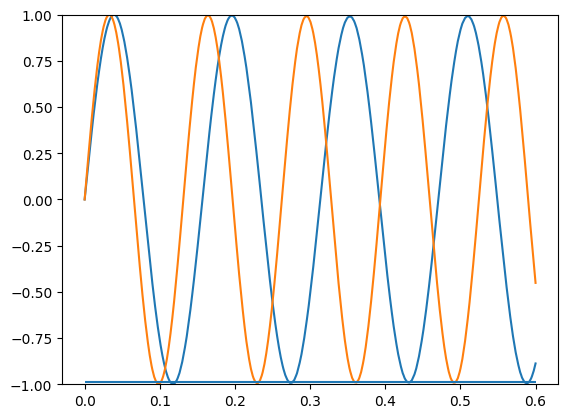

In [100]:
# Define time points
times = np.linspace(0, 0.6, 500)  # Example: from 0 to 10 with 100 points
# Evolve the state under the Hamiltonian
output_00 = CR(times, psidown, Hp, e_op_list)
output_10 = CR(times, psiup, Hp, e_op_list)

plt.plot(times, output_00[4])
plt.plot(times, output_10[4])
plt.ylim([-1, 1])
plt.hlines(-1 + 0.01, xmin = 0, xmax = 0.6)

In [101]:
output_00_echo = CR_echo(times, psidown, Hp, Hm, e_op_list)
output_10_echo = CR_echo(times, psiup, Hp, Hm, e_op_list)

(-1.0, 1.0)

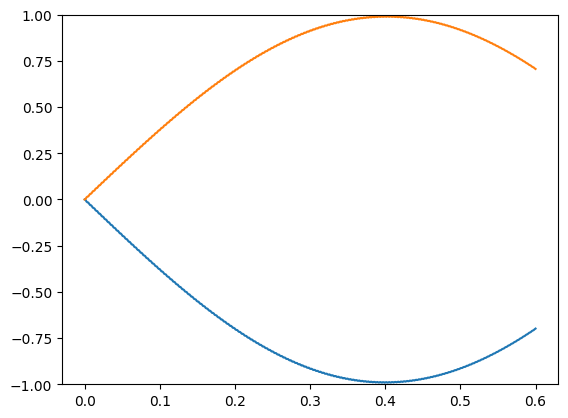

In [102]:
plt.plot(times, output_00_echo[4])
plt.plot(times, output_10_echo[4])
plt.ylim([-1, 1])

In [11]:
import pennylane as qml
from pennylane import numpy as np

# Define a two-qubit device
dev = qml.device("default.qubit", wires=2)

# Define a quantum circuit
@qml.qnode(dev)
def circuit():
    # Apply a Hadamard gate to the first qubit
    # qml.Hadamard(wires=0)
    
    # Apply a CNOT gate (control=qubit 0, target=qubit 1)
    qml.X(0)
    qml.ECR(wires=[0, 1])
    
    # Return the expectation values of Pauli matrices for each qubit
    return [qml.expval(qml.PauliX(0)), qml.expval(qml.PauliY(0)), qml.expval(qml.PauliZ(0)),
            qml.expval(qml.PauliX(1)), qml.expval(qml.PauliY(1)), qml.expval(qml.PauliZ(1))]

# Execute the circuit
exp_vals = circuit()

# Print the results
print(f"Expectation values for qubit 0:")
print(f"⟨X⟩ = {exp_vals[0]}")
print(f"⟨Y⟩ = {exp_vals[1]}")
print(f"⟨Z⟩ = {exp_vals[2]}")

print(f"\nExpectation values for qubit 1:")
print(f"⟨X⟩ = {exp_vals[3]}")
print(f"⟨Y⟩ = {exp_vals[4]}")
print(f"⟨Z⟩ = {exp_vals[5]}")


Expectation values for qubit 0:
⟨X⟩ = 0.0
⟨Y⟩ = 0.0
⟨Z⟩ = 0.9999999999999998

Expectation values for qubit 1:
⟨X⟩ = 0.0
⟨Y⟩ = 0.9999999999999996
⟨Z⟩ = 0.0
